In [7]:
import ccxt
import pandas as pd

try:
    exchange = ccxt.binance()
    symbol = 'BTC/USDT'
    timeframe = '1h'
    limit = 1000

    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df.to_csv('bitcoin_1h.csv', index=False)
    print("✅ CSV 저장 완료")

except Exception as e:
    print("❌ 에러 발생:", e)


✅ CSV 저장 완료


In [9]:
!pip install ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29422 sha256=d3574f1e4a48ed44615771d92666aafdb4a48b504c6e11049df028cc1948e3d9
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\a1\d7\29\7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [19]:
"""
📌 기술적 지표 컬럼 단위 기준 정리

- returns (%)         : 수익률, 전 시간 대비 변화율 (%)
- sma_20 (USD)        : 20시간 단순 이동 평균 (달러)
- ema_20 (USD)        : 20시간 지수 이동 평균 (달러)
- volatility_20 (σ%)  : 20시간 수익률의 표준편차 (%, σ 단위)
- rsi (0~100)         : 상대강도지수 (Relative Strength Index)
- bb_bbm (USD)        : 볼린저 밴드 중앙선 (20기간 평균, 달러)
- bb_bbh (USD)        : 볼린저 밴드 상단 (20기간 평균 + 2σ)
- bb_bbl (USD)        : 볼린저 밴드 하단 (20기간 평균 - 2σ)
"""

import pandas as pd
import ta

# 데이터 불러오기 및 시간 인덱스 설정
df = pd.read_csv('bitcoin_1h.csv', parse_dates=['timestamp'])
df = df.set_index('timestamp')

# 기술적 지표 계산 + 컬럼명에 단위 추가
df['returns (%)'] = df['close'].pct_change() * 100  # 퍼센트로 환산
df['sma_20 (USD)'] = df['close'].rolling(window=20).mean()
df['ema_20 (USD)'] = df['close'].ewm(span=20, adjust=False).mean()
df['volatility_20 (σ%)'] = df['returns (%)'].rolling(window=20).std()  # 퍼센트 기준 표준편차
df['rsi (0~100)'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()

# Bollinger Bands (20기간, ±2σ)
bb = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['bb_bbm (USD)'] = bb.bollinger_mavg()
df['bb_bbh (USD)'] = bb.bollinger_hband()
df['bb_bbl (USD)'] = bb.bollinger_lband()

# 결과 확인
df.tail()






,open,high,low,close,volume,returns (%),sma_20 (USD),ema_20 (USD),volatility_20 (σ%),rsi (0~100),bb_bbm (USD),bb_bbh (USD),bb_bbl (USD)
timestamp,,,,,,,,,,,,,
2025-05-13 02:00:00,102400.48,102701.82,101696.84,102067.99,924.66581,-0.324696,103091.3955,102901.231185,0.511016,39.072527,103091.3955,104988.572840,101194.218160
2025-05-13 03:00:00,102067.98,102166.99,101429.70,101719.40,962.27648,-0.341527,102953.9660,102788.675834,0.511427,36.347891,102953.9660,104830.453739,101077.478261
2025-05-13 04:00:00,101719.40,102767.24,101610.56,102745.71,1132.24142,1.008962,102860.5495,102784.583850,0.569381,47.873064,102860.5495,104576.301417,101144.797583
2025-05-13 05:00:00,102745.72,102745.72,102264.34,102477.15,1000.99313,-0.261383,102761.4400,102755.304435,0.570568,45.548934,102761.4400,104317.938214,101204.941786
2025-05-13 06:00:00,102477.16,102688.77,102333.33,102518.39,825.83527,0.040243,102660.9785,102732.741156,0.570226,45.982610,102660.9785,103991.487027,101330.469973


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


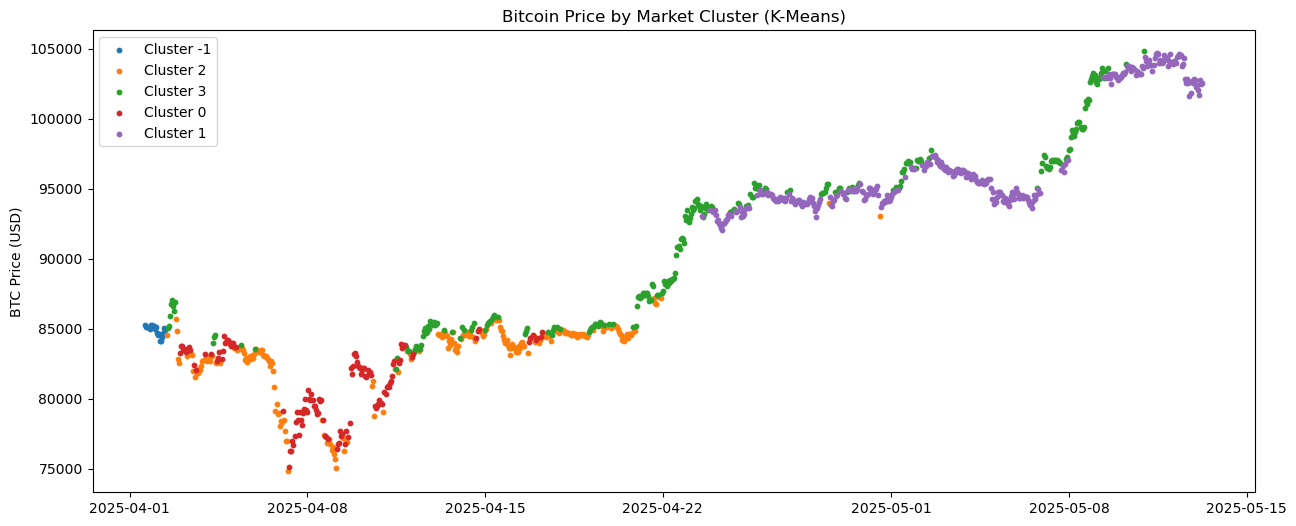

In [22]:
features = df[['returns (%)', 'sma_20 (USD)', 'volatility_20 (σ%)', 'rsi (0~100)']]
features = features.dropna()  # 결측치 제거
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
from sklearn.cluster import KMeans

k = 4  # 군집 개수: 3~6개가 일반적. 바꿔가며 테스트 가능
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)
df.loc[features.index, 'market_state'] = cluster_labels
df['market_state'] = df['market_state'].fillna(-1).astype(int)  # 여기를 이렇게 수정

import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
for cluster in df['market_state'].dropna().unique():
    cluster_data = df[df['market_state'] == cluster]
    plt.scatter(cluster_data.index, cluster_data['close'], label=f'Cluster {cluster}', s=10)

plt.legend()
plt.title("Bitcoin Price by Market Cluster (K-Means)")
plt.ylabel("BTC Price (USD)")
plt.show()

              precision    recall  f1-score   support

          -1       0.27      0.10      0.14        31
           0       0.52      0.88      0.65       106
           1       0.14      0.02      0.03        59

    accuracy                           0.49       196
   macro avg       0.31      0.33      0.28       196
weighted avg       0.37      0.49      0.39       196

[[ 3 28  0]
 [ 7 93  6]
 [ 1 57  1]]


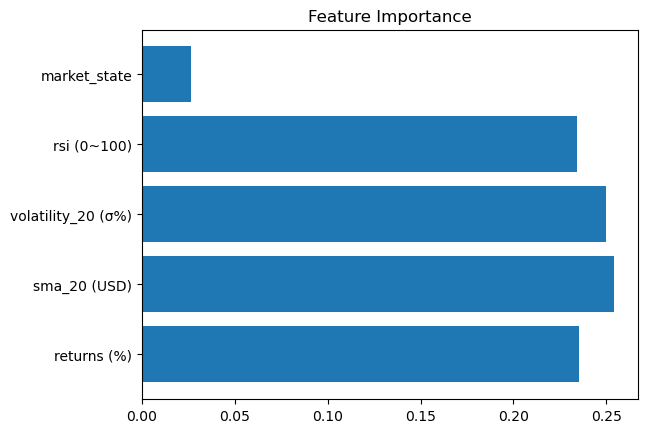

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. 수익률 계산 및 **3단계 라벨 설정**
def classify_return(x):
    if x > 0.002:
        return 1   # 상승
    elif x < -0.003:
        return -1  # 하락
    else:
        return 0   # 횡보

df['future_return'] = (df['close'].shift(-1) - df['close']) / df['close']
df['target'] = df['future_return'].apply(classify_return)

# 2. 피처 설정 및 결측치 제거
features = ['returns (%)', 'sma_20 (USD)', 'volatility_20 (σ%)', 'rsi (0~100)', 'market_state']
df_model = df[features + ['target']].dropna()

X = df_model[features]
y = df_model['target']

# 3. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# 4. RandomForest 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# 5. 성능 평가
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# 6. 피처 중요도 시각화
importances = model.feature_importances_
plt.barh(X.columns, importances)
plt.title("Feature Importance")
plt.show()


In [31]:
df['target'].value_counts(normalize=True)


target
0    0.899
1    0.101
Name: proportion, dtype: float64

In [37]:
print(df['target'].value_counts())
print(df['target'].value_counts(normalize=True).round(3))  # 비율로 보기


target
 0    457
 1    188
-1    169
 2    101
-2     85
Name: count, dtype: int64
target
 0    0.457
 1    0.188
-1    0.169
 2    0.101
-2    0.085
Name: proportion, dtype: float64


In [38]:
pip install scikit-plot


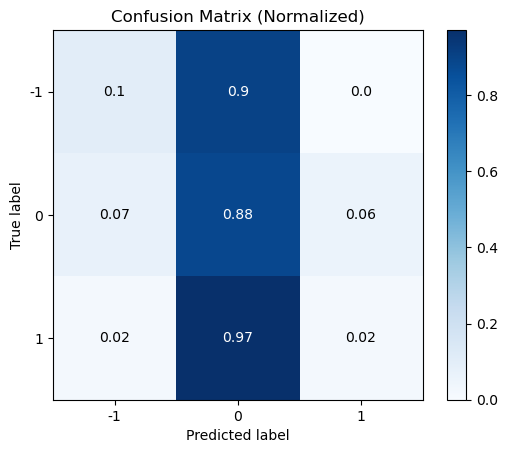

Macro F1-score: 0.276


In [43]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.title("Confusion Matrix (Normalized)")
plt.show()
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)
print("Macro F1-score:", round(report['macro avg']['f1-score'], 3))
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
